In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

C:\Users\Pehansi Karunaratne\AppData\Local\Temp\ipykernel_15536\3064049372.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Loading data
df = pd.read_csv('Datasets/balanced_augmented_NewDepartments_dataset.csv')
print(df.shape)

(420, 2)


In [5]:
df.head(3).T #Display First 3 lines

,0,1,2
Complaints,I have a phone connection also in this number ...,My internet speed is much slower than what I'm...,I need to just make it a high priority because...
Department,Technical,Technical,Technical


In [6]:
pd.DataFrame(df.Department.unique()).values #Get unique values in department column

array([['Technical'],
       ['Billing'],
       ['HR']], dtype=object)

In [7]:
# Create a new column 'department_id' with encoded Departments
df2 = df.sample(420, random_state=1).copy()
df2['department_id'] = df2['Department'].factorize()[0]
department_id_df = df2[['Department', 'department_id']].drop_duplicates()
# Dictionaries for future use
department_to_id = dict(department_id_df.values)
id_to_department = dict(department_id_df[['department_id', 'Department']].values)
# New dataframe
df2.head()

,Complaints,Department,department_id
378,The representative was unprofessional during o...,HR,0
165,Is it not possibly a disconnection due to loss...,Billing,1
17,"I frequently travel to a specific area, and th...",Technical,2
179,There are some fees on my bill that weren't di...,Billing,1
4,"I want to log a complaint that my internet, TV...",Technical,2


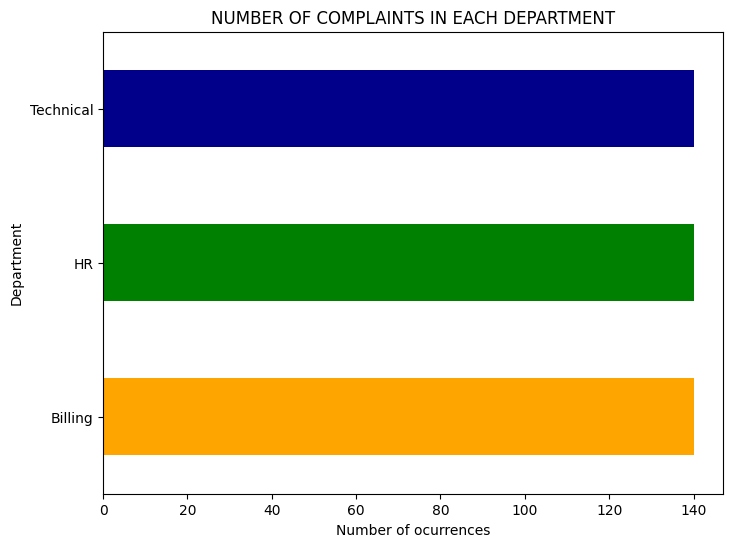

In [8]:
#Plot to see number of complaints in each department
ig = plt.figure(figsize=(8,6))
colors = ['orange','green','darkblue',]
df2.groupby('Department').Complaints.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH DEPARTMENT')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [9]:
X = df2['Complaints'] # Collection of documents
y = df2['Department'] # Labels we want to predict
#Splitting data into training and testing
#test_size=0.25 means 25% of data will be using for testing and 75% of data will be used to train the model
#random_state = 0 means, when the code is run multiple times, it will get the same split each time
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

In [10]:
models = [
    SVC(kernel='linear', C=1),

]
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
features = tfidf.fit_transform(df2.Complaints).toarray()
labels = df2.department_id
# 3 Cross-validation
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,SVC,0,0.871429
1,SVC,1,0.957143
2,SVC,2,0.921429


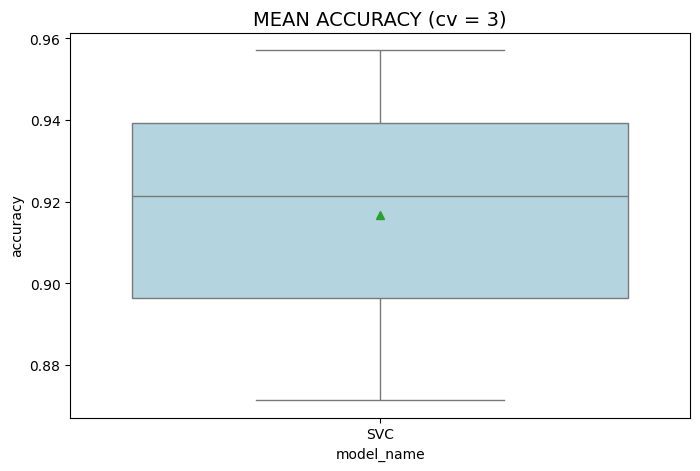

In [11]:
# Set up the plot with a specific figure size
plt.figure(figsize=(8, 5))

# Create a boxplot to visualize the distribution of accuracy scores for the single model
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',  # Set the color of the boxes
            showmeans=True)    # Display the mean value as a diamond marker

# Add a title to the plot
plt.title("MEAN ACCURACY (cv = 3)", size=14)

# Display the plot
plt.show()


In [12]:
# Split the data into training and testing sets
# The third argument (df2.index) represents the indices of the original DataFrame
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,
                                                                               labels,
                                                                               df2.index,
                                                                               test_size=0.25,
                                                                               random_state=1)

# Create a SVM with specific parameters
model = SVC(kernel='linear', C=1)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)


In [13]:
# Classification report
print('CLASSIFICATIION METRICS')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Department'].unique()))

CLASSIFICATIION METRICS
              precision    recall  f1-score   support

          HR       0.88      0.97      0.92        30
     Billing       1.00      0.79      0.88        38
   Technical       0.88      1.00      0.94        37

    accuracy                           0.91       105
   macro avg       0.92      0.92      0.91       105
weighted avg       0.92      0.91      0.91       105



In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=0)

# Create a TF-IDF vectorizer with specific parameters
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# Fit the vectorizer on the training data
fitted_vectorizer = tfidf.fit(X_train)

# Transform the training data into TF-IDF vectors
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

# Create a SVM with specific parameters and fit it on the TF-IDF vectors and corresponding labels
model = SVC(kernel='linear', C=1).fit(tfidf_vectorizer_vectors, y_train)


In [16]:
complaint = """I need to know the balance of my bill"""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)


Billing


In [17]:
complaint = """One of your agent was so rude to me"""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)

HR


In [18]:
complaint = """My data is not working and i can't send messages"""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)

Technical


In [19]:
complaint = """Previous agent ignored my call and didn't gave me a proper response"""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)

HR


In [20]:
complaint = """I was billed for a service i cancelled last year"""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)

Billing


In [21]:
complaint = """There have been consistent discrepancies in the charges reflected on my monthly statements.
Despite selecting a specific plan with clearly defined costs, I have noticed unauthorized fees and unexplained increases in my bills.
This lack of transparency has left me frustrated and confused about the actual charges for the services I am receiving."""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)

Billing


In [22]:
complaint = """The customer service agent I spoke to demonstrated
a complete lack of empathy towards my concerns. Instead of actively listening
and understanding the issue, the agent seemed disinterested and indifferent."""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)

HR


In [23]:
complaint = """Despite numerous attempts to troubleshoot the problem on my end, including resetting the router, checking for software updates,
and ensuring proper device configurations, the WiFi connection remains unstable and frequently disconnects. This has severely impacted my ability to work,
engage in online meetings, and enjoy a seamless internet experience."""
prediction = model.predict(fitted_vectorizer.transform([complaint]))[0]

print(prediction)

Technical
